In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral

init_notebook_mode(connected=True)



In [2]:
X=loadmat('../input/salinas/salinas_corrected.mat')['salinas_corrected']
y=loadmat('../input/salinas/salinas_gt.mat')['salinas_gt']

In [3]:
test_ratio=0.7
pixelsize=25

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [5]:
X.shape, y.shape

((512, 217, 204), (512, 217))

In [6]:
X,pca=applyPCA(X,numComponents=15)
X.shape

(512, 217, 15)

In [7]:
X, y = createImageCubes(X, y, windowSize=25)

X.shape, y.shape

((54129, 25, 25, 15), (54129,))

In [8]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((16238, 25, 25, 15), (37891, 25, 25, 15), (16238,), (37891,))

In [9]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((10825, 25, 25, 15), (5413, 25, 25, 15), (10825,), (5413,))

In [10]:
Xtrain = Xtrain.reshape(-1, pixelsize, pixelsize, 15, 1)
Xtrain.shape

(10825, 25, 25, 15, 1)

In [11]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(10825, 16)

In [12]:
Xvalid = Xvalid.reshape(-1, pixelsize, pixelsize, 15, 1) 
Xvalid.shape

(5413, 25, 25, 15, 1)

In [13]:
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(5413, 16)

In [14]:
input_layer=Input((25,25,15,1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)

(None, 19, 19, 3, 32)


2022-12-16 11:55:21.897655: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model=Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [16]:
adam=Adam(learning_rate=0.001,decay=1e-06)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
filepath = "best-model.hdf5"
metric='acc'
checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
callback_list=[checkpoint]

In [18]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),batch_size=256,epochs=10,callbacks=callback_list)

2022-12-16 11:55:22.620711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
43/43 [==============================] - 36s 822ms/step - loss: 0.7046 - accuracy: 0.7727 - val_loss: 0.0275 - val_accuracy: 0.9924
Epoch 2/10
43/43 [==============================] - 35s 825ms/step - loss: 0.0671 - accuracy: 0.9782 - val_loss: 0.0085 - val_accuracy: 0.9972
Epoch 3/10
43/43 [==============================] - 35s 814ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0068 - val_accuracy: 0.9980
Epoch 4/10
43/43 [==============================] - 35s 815ms/step - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0.0081 - val_accuracy: 0.9989
Epoch 5/10
43/43 [==============================] - 35s 814ms/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
43/43 [==============================] - 35s 813ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 7/10
43/43 [==============================] - 35s 815ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 7.3755e-04 - val_accuracy: 0.

In [19]:
model.save("best-model1.hdf5")

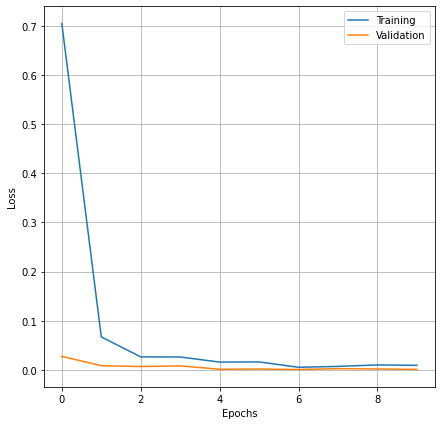

In [20]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()



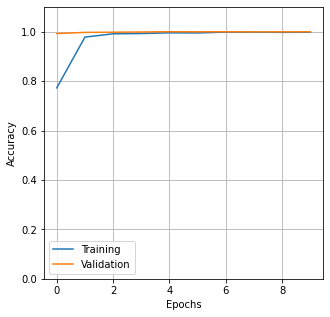

In [21]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [22]:
model.load_weights=("best-model1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [23]:
Xtest=Xtest.reshape(-1,pixelsize,pixelsize,15,1)
Xtest.shape

(37891, 25, 25, 15, 1)

In [24]:
ytest=np_utils.to_categorical(ytest)
ytest.shape

(37891, 16)

In [25]:
Y_pred_test=model.predict(Xtest)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(ytest,axis=1),Y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1406
           1       1.00      1.00      1.00      2608
           2       1.00      1.00      1.00      1383
           3       1.00      1.00      1.00       976
           4       1.00      1.00      1.00      1875
           5       1.00      1.00      1.00      2771
           6       1.00      1.00      1.00      2505
           7       1.00      1.00      1.00      7890
           8       1.00      1.00      1.00      4342
           9       1.00      1.00      1.00      2295
          10       1.00      1.00      1.00       748
          11       1.00      1.00      1.00      1349
          12       1.00      1.00      1.00       641
          13       1.00      1.00      1.00       749
          14       1.00      1.00      1.00      5088
          15       1.00      1.00      1.00      1265

    accuracy                           1.00     37891
   macro avg       1.00   

In [26]:
import time
def AA_andEachClassAccuracy(confusion_matrix):
    counter= confusion_matrix[0]
    list_diag= np.diag(confusion_matrix)
    list_raw_sum= np.sum(confusion_matrix,axis=1)
    each_acc=np.nan_to_num(truediv(list_diag,list_raw_sum))
    average_acc=np.mean(each_acc)
    return each_acc, average_acc
def reports(X_test,y_test,name):
    start=time.time()
    Y_pred=model.predict(X_test)
    y_pred=np.argmax(Y_pred,axis=1)
    end=time.time()
    print(end-start)
    target_names= ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
    oa=accuracy_score(np.argmax(y_test,axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [27]:
dataset='SU'
import os 
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

37.75221872329712
1185/1185 [==============================] - 36s 30ms/step - loss: 4.2865e-04 - accuracy: 0.9999


In [28]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [29]:
X=loadmat('../input/salinas/salinas_corrected.mat')['salinas_corrected']
y=loadmat('../input/salinas/salinas_gt.mat')['salinas_gt']

In [30]:
height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [31]:
X,pca=applyPCA(X,numComponents=numComponents)


In [32]:
X=padWithZeros(X,PATCH_SIZE//2)


In [33]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

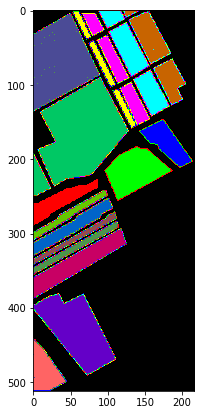

In [34]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


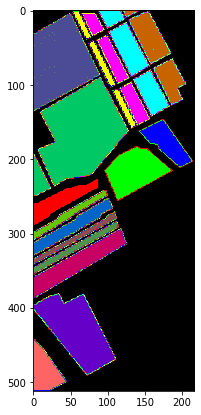

In [35]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [36]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
